# Crisis Proximity Index
[Guardian timeline](https://www.theguardian.com/business/2012/aug/07/credit-crunch-boom-bust-timeline)

In [1]:
# load skyfield and ephemeris
from skyfield.api import load, Loader
from astropy import units as u

# Skyfield data
load = Loader('../_data/skyfield')
planets = load('de421.bsp')
ts = load.timescale()

[#################################] 100% deltat.preds


In [2]:
import numpy as np
from datetime import date

In [3]:
earth = planets['earth']
planet_list = {
    'mercury': planets['mercury'],
    'venus': planets['venus'], 
    'mars': planets['mars'],
    'jupiter': planets['jupiter barycenter']
    #'saturn': planets['saturn barycenter'],
    #'uranus': planets['uranus barycenter'],
    #'neptune': planets['neptune barycenter']
    }

crisis_date = date(2007, 8, 9)

def crisis_pos(planet):
    astrometric = earth.at(ts.utc(crisis_date)).observe(planet_list[planet])
    crisis_pos = astrometric.position.au
    return crisis_pos
    
crisis_pos('mars')

array([0.61968595, 1.03664375, 0.42279154])

In [4]:
from scipy.spatial import distance
import pandas as pd
import datetime

future = date.today() + datetime.timedelta(days = 5)
time_diff = future - (crisis_date - datetime.timedelta(days = 1))
time_range = time_diff.days
dates = []

for n in range(time_range):
    d = datetime.timedelta(days=n)
    dates.append(future - d)

# fill df with datetime index and mars positions
df = pd.DataFrame(data = dates, columns=['date'])
df = df.iloc[::-1] #reverse
df.head()

date
3905  2007-08-09
3904  2007-08-10
3903  2007-08-11
3902  2007-08-12
3901  2007-08-13

In [5]:
def planet_pos(x, planet):
    astrometric = earth.at(ts.utc(x)).observe(planet_list[planet])
    return astrometric.position.au

def dist_to_crisis(x, planet):
    d = distance.euclidean(crisis_pos(planet), x)
    return d

for p in planet_list:
    pos_colname = str(p) + '_pos'
    crisis_colname = str(p) + '_dist'
    df[pos_colname] = df['date'].apply(planet_pos, args = (p,))
    df[crisis_colname] = df[pos_colname].apply(dist_to_crisis, args = (p,))
    df.drop(pos_colname, axis = 1, inplace = True)
    
df.head()

date  venus_dist  mercury_dist  mars_dist  jupiter_dist
3905  2007-08-09    0.000000      0.000000   0.000000      0.000000
3904  2007-08-10    0.003692      0.048307   0.015385      0.014022
3903  2007-08-11    0.007277      0.096750   0.030668      0.028159
3902  2007-08-12    0.010757      0.145176   0.045848      0.042412
3901  2007-08-13    0.014138      0.193443   0.060925      0.056779

In [6]:
df['total'] = df.sum(axis=1)
df.head()

date  venus_dist  mercury_dist  mars_dist  jupiter_dist     total
3905  2007-08-09    0.000000      0.000000   0.000000      0.000000  0.000000
3904  2007-08-10    0.003692      0.048307   0.015385      0.014022  0.081406
3903  2007-08-11    0.007277      0.096750   0.030668      0.028159  0.162854
3902  2007-08-12    0.010757      0.145176   0.045848      0.042412  0.244193
3901  2007-08-13    0.014138      0.193443   0.060925      0.056779  0.325284

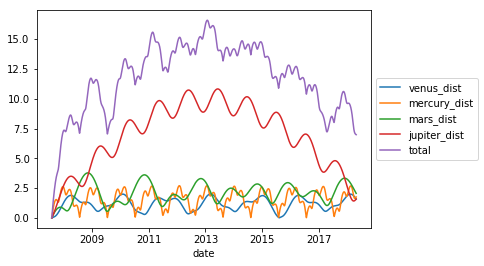

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
f = plt.figure()

df.plot.line(x=["date"], ax=f.gca())
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [8]:
df.loc[df["date"] == date(2007, 8, 9)]

date  venus_dist  mercury_dist  mars_dist  jupiter_dist  total
3905  2007-08-09         0.0           0.0        0.0           0.0    0.0

In [9]:
df['mercury_diff'] = df['mercury_dist'].diff()
df['venus_diff'] = df['venus_dist'].diff()
df['mars_diff'] = df['mars_dist'].diff()
df['jupiter_diff'] = df['jupiter_dist'].diff()
df['total_diff'] = df['total'].diff()

df.fillna(value = 0, inplace = True)
df.head()

date  venus_dist  mercury_dist  mars_dist  jupiter_dist     total  \
3905  2007-08-09    0.000000      0.000000   0.000000      0.000000  0.000000   
3904  2007-08-10    0.003692      0.048307   0.015385      0.014022  0.081406   
3903  2007-08-11    0.007277      0.096750   0.030668      0.028159  0.162854   
3902  2007-08-12    0.010757      0.145176   0.045848      0.042412  0.244193   
3901  2007-08-13    0.014138      0.193443   0.060925      0.056779  0.325284   

      mercury_diff  venus_diff  mars_diff  jupiter_diff  total_diff  
3905      0.000000    0.000000   0.000000      0.000000    0.000000  
3904      0.048307    0.003692   0.015385      0.014022    0.081406  
3903      0.048443    0.003584   0.015283      0.014138    0.081448  
3902      0.048426    0.003480   0.015180      0.014253    0.081339  
3901      0.048267    0.003381   0.015076      0.014367    0.081091

In [10]:
def scale_diff(x, colmin, colmax):
    if x > 0.0:
        return x / colmax
    elif x < 0.0:
        return 0 - (x / colmin)
    else:
        return 0.0
    

In [11]:
diff_columns = ['mercury_diff', 'venus_diff', 'mars_diff', 'jupiter_diff', 'total_diff']

for colname in diff_columns:
    df[colname] = df[colname].apply(scale_diff, args=(df[colname].min(), df[colname].max(),))

In [12]:
today = date.today()
offset = datetime.timedelta(days=5)

start = today - offset
end = today + offset

crisis_matrix = df.loc[df['date'] >= start]
crisis_matrix.to_csv("crisis_matrix.csv", index=False)
crisis_matrix

date  venus_dist  mercury_dist  mars_dist  jupiter_dist     total  \
10  2018-04-08    1.681180      1.676259   2.181252      1.502815  7.041505   
9   2018-04-09    1.671828      1.683555   2.169186      1.509886  7.034455   
8   2018-04-10    1.662370      1.691203   2.157157      1.517166  7.027896   
7   2018-04-11    1.652809      1.699120   2.145167      1.524646  7.021741   
6   2018-04-12    1.643146      1.707227   2.133218      1.532317  7.015908   
5   2018-04-13    1.633383      1.715454   2.121313      1.540169  7.010319   
4   2018-04-14    1.623522      1.723733   2.109455      1.548195  7.004904   
3   2018-04-15    1.613565      1.732002   2.097646      1.556383  6.999597   
2   2018-04-16    1.603514      1.740205   2.085890      1.564726  6.994336   
1   2018-04-17    1.593371      1.748288   2.074189      1.573215  6.989063   
0   2018-04-18    1.583138      1.756201   2.062545      1.581840  6.983725   

    mercury_diff  venus_diff  mars_diff  jupiter_diff  total_diff  
10      0.141513   -0.714799  -0.618336      0.299807   -0.122991  
9       0.150616   -0.723080  -0.616612      0.309363   -0.113553  
8       0.157875   -0.731225  -0.614760      0.318515   -0.105632  
7       0.163417   -0.739232  -0.612777      0.327265   -0.099131  
6       0.167360   -0.747099  -0.610661      0.335614   -0.093953  
5       0.169820   -0.754822  -0.608410      0.343562   -0.090007  
4       0.170903   -0.762401  -0.606020      0.351111   -0.087209  
3       0.170709   -0.769830  -0.603491      0.358263   -0.085478  
2       0.169331   -0.777105  -0.600822      0.365020   -0.084740  
1       0.166853   -0.784220  -0.598012      0.371384   -0.084927  
0       0.163353   -0.791167  -0.595062      0.377357   -0.085976